In [0]:
## MNIST FASHION DATASET. FEDERATED LEARNING CHALLENGE 

In [0]:
!pip install tf-encrypted

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

     |████████████████████████████████| 2.1MB 6.4MB/s 
     |████████████████████████████████| 276kB 37.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'PySyft'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 28691 (delta 1), reused 3 (delta 0), pack-reused 28684
Receiving objects: 100% (28691/28691), 32.07 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (19020/19020), done.
zip_safe flag not set; analyzing archive contents...
zip_safe flag not set; analyzing archive contents...
__pycache__.zstd.cpython-36: module references __file__
     |████████████████████████████████| 389kB 6.3MB/s 
ERROR: syft 0.1.21a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0.5.6 whi

In [0]:
import torch
import torchvision
from torchvision import datasets, transforms

In [0]:
import syft as sy
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook,id = "bob")
alice = sy.VirtualWorker(hook,id="alice")
#secure_worker =  sy.VirtualWorker(hook, id ="secure_worker")

W0723 17:08:17.773959 140254352459648 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0723 17:08:17.794449 140254352459648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
fed_trainset = trainset.federate((bob,alice))
print(fed_trainset)
trainloader = sy.FederatedDataLoader(fed_trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9019639.22it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135093.06it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2201456.80it/s]                           
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50718.40it/s]            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
FederatedDataset
    Distributed accross: bob, alice
    Number of datapoints: 60000



In [0]:
data, labels = next(iter(trainloader))
print(data,labels)
data.location
labels.location

(Wrapper)>[PointerTensor | me:67238559141 -> bob:55737772491] (Wrapper)>[PointerTensor | me:29132788659 -> bob:26496611217]


<VirtualWorker id:bob #objects:4>

In [0]:
## TODO: Define your model with dropout added
from torch import nn, optim
import torch.nn.functional as F
class Clasifier(nn.Module):
    def __init__(self):
        super().__init__()
        #define layers
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        #drop out p=0.2
        #self.dropout = nn.Dropout(p=0.2)
        
    def forward (self,x):
        x = x.view(x.shape[0],-1)
        
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
            

In [0]:
model = Clasifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [0]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])


In [0]:
equals = top_class == labels.view(*top_class.shape)
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 6.25%


In [0]:
model = Clasifier()
optimizer = optim.SGD(params= model.parameters(),lr=0.003)
criterion = nn.NLLLoss()

In [0]:
def train (trainloader, model, optimizer, criterion):
    model.train()
    step = 0
    train_losses =[]
    running_loss = 0
    
    for images, labels in trainloader:
   
        model.send (images.location)
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        loss = loss.get()
        running_loss += loss.item()
        
        model = model.get()
        
        train_losses.append(running_loss/len(trainloader))
    print ("Epoch: {}/{}.. ".format(e+1, epochs),
           "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)))

In [0]:
def test (testloader, model, optimizer, criterion):
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)
            
            ps = torch.exp(log_ps)
            top_p,top_class = ps.topk(1,dim=1)
            equals=top_class==labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            
    print ("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
           "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

In [0]:
epochs = 20
for e in range (epochs):
    train (trainloader, model, optimizer, criterion)
    test(testloader, model, optimizer, criterion)

Epoch: 1/20..  Training Loss: 0.301.. 
Test Loss: 0.287..  Test Accuracy: 0.914
Epoch: 2/20..  Training Loss: 0.290.. 
Test Loss: 0.277..  Test Accuracy: 0.918
Epoch: 3/20..  Training Loss: 0.280.. 
Test Loss: 0.267..  Test Accuracy: 0.923
Epoch: 4/20..  Training Loss: 0.270.. 
Test Loss: 0.263..  Test Accuracy: 0.923
Epoch: 5/20..  Training Loss: 0.261.. 
Test Loss: 0.250..  Test Accuracy: 0.928
Epoch: 6/20..  Training Loss: 0.252.. 
Test Loss: 0.241..  Test Accuracy: 0.929
Epoch: 7/20..  Training Loss: 0.243.. 
Test Loss: 0.235..  Test Accuracy: 0.931
Epoch: 8/20..  Training Loss: 0.234.. 
Test Loss: 0.230..  Test Accuracy: 0.933
Epoch: 9/20..  Training Loss: 0.225.. 
Test Loss: 0.220..  Test Accuracy: 0.935
Epoch: 10/20..  Training Loss: 0.217.. 
Test Loss: 0.212..  Test Accuracy: 0.938
Epoch: 11/20..  Training Loss: 0.209.. 
Test Loss: 0.209..  Test Accuracy: 0.938
Epoch: 12/20..  Training Loss: 0.202.. 
Test Loss: 0.199..  Test Accuracy: 0.941
Epoch: 13/20..  Training Loss: 0.194.

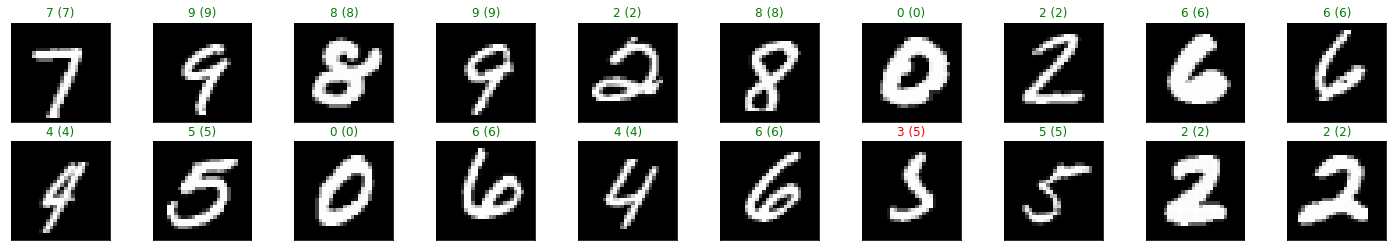

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))